In [1]:
import numpy as np
import uproot as ur
import h5py as h5
from keras.layers import Dense, Input
from keras.models import Model

import omnifold as of
import os
import tensorflow as tf

from matplotlib import pyplot as plt
from IPython.display import Image

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU')]


# [Omnifold Paper](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.124.182001) Background

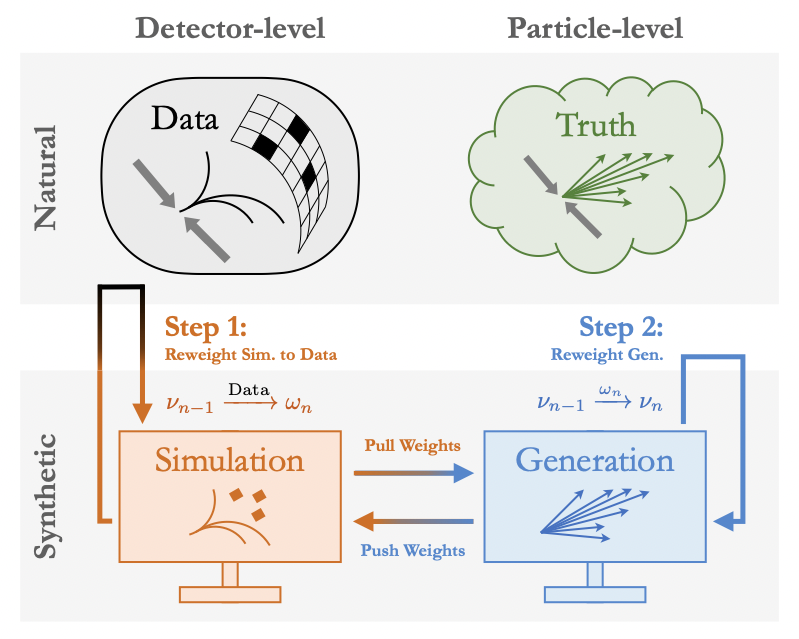

In [3]:
Image(filename='Omnifold.png')

|   |   |   |
|---|---|---|
|Synthetic Generator-Level Sim   | $\theta_{0,G}$  | Truth-Level Sim  |
|Synthetic Reconstruction-Level Sim   | $\theta_{0,S}$   | Full Reco-Level Sim  |
|Natural Reconstruction  | $\theta_\mathrm{unknown,S}$  | Observed Detector Data  |
|Natural Truth   |$\theta_\mathrm{unknown,G}$   | Nature  |


___
___

# OmniFold Example 1: 1D Gaussian [[Original Repo](https://github.com/hep-lbdl/OmniFold)]

In [4]:
N_Events = 10**5

# Synthetic
theta0_G = np.random.normal(0.2, 0.8, N_Events)  # Generator-level synthetic sample
theta0_S = np.array([(x + np.random.normal(0, 0.5)) for x in theta0_G])  # Detector smearing for synthetic sample

theta0 = np.stack([theta0_G, theta0_S], axis=1)

# Natural
theta_unknown_G = np.random.normal(0, 1, N_Events)
theta_unknown_S = np.array([(x + np.random.normal(0, 0.5)) for x in theta_unknown_G])

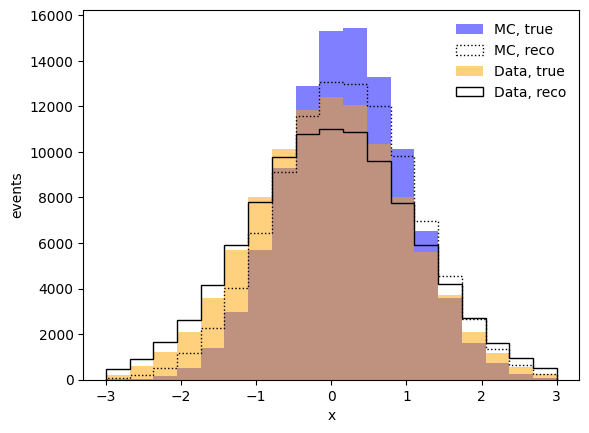

In [5]:
_, _, _ = plt.hist(theta0_G, bins=np.linspace(-3, 3, 20), color='blue', alpha=0.5, label="MC, true")
_, _, _ = plt.hist(theta0_S, bins=np.linspace(-3, 3, 20), histtype="step", color='black', ls=':', label="MC, reco")
_, _, _ = plt.hist(theta_unknown_G, bins=np.linspace(-3, 3, 20), color='orange', alpha=0.5, label="Data, true")
_, _, _ = plt.hist(theta_unknown_S, bins=np.linspace(-3, 3, 20), histtype="step", color='black', label="Data, reco")
plt.xlabel("x")
plt.ylabel("events")
plt.legend(frameon=False)

### Define the Model Architecture

In [6]:
inputs = Input((1,))
hidden_layer_1 = Dense(50, activation='relu')(inputs)
hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)
outputs = Dense(1, activation='sigmoid')(hidden_layer_3)
model_gaus = Model(inputs=inputs, outputs=outputs)

In [7]:
N_Iterations = 2
myweights = of.omnifold(theta0_G, theta0_S, theta_unknown_S, N_Iterations, model_gaus)


ITERATION: 1

STEP 1

10/10 [==============================] - 0s 754us/step

STEP 2

10/10 [==============================] - 0s 741us/step

ITERATION: 2

STEP 1

10/10 [==============================] - 0s 784us/step

STEP 2

10/10 [==============================] - 0s 793us/step


### Plot Omnifold, the weighted $\theta_G$ distribution

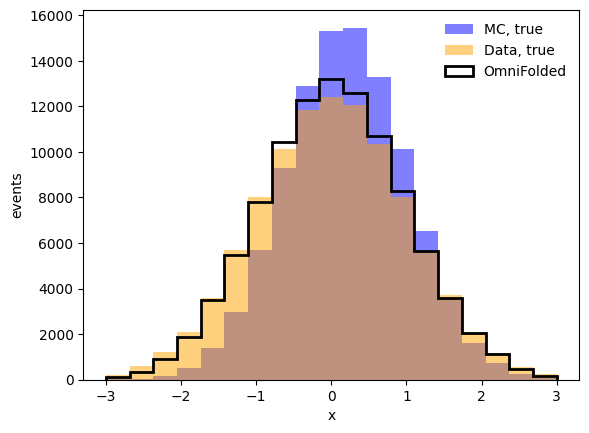

In [8]:
_, _, _ = plt.hist(theta0_G, bins=np.linspace(-3, 3, 20), color='blue', alpha=0.5, label="MC, true")
_, _, _ = plt.hist(theta_unknown_G, bins=np.linspace(-3, 3, 20), color='orange', alpha=0.5, label="Data, true")
_, _, _ = plt.hist(
    theta0_G,
    weights=myweights[-1, 1, :],
    bins=np.linspace(-3, 3, 20),
    color='black',
    histtype="step",
    label="OmniFolded",
    lw=2,
)
plt.xlabel("x")
plt.ylabel("events")
plt.legend(frameon=False)

### $\rightarrow$ Try increasing from 2 to 5 iterations yourself

___
___

# Omnifold Example 2: Realistic DIS Reconstruction – Lepton + HFS

### Many thanks to _Miguel Arratia, Owen Long_, and _Daniel Britzger_ for letting us use their data from this awesome [paper   ](https://www.sciencedirect.com/science/article/pii/S0168900221010445?ref=cra_js_challenge&fr=RR-1) on reconstructing DIS events using Deep Learning.

### Import "Natural." In this tutorial, reconstructed-level Django will be our proxy of *_measured data_*.

In [9]:
path_to_file = '/global/cfs/cdirs/ntrain2/unfolding'

In [10]:
natural_file = h5.File(os.path.join(path_to_file, "django.h5"), "r")  # Proxy for the data we are going to use for unfolding

## Import the Synthetic simulation [Rapgap], both generated and reconstructed level.

In [11]:
synthetic_file = h5.File(
    os.path.join(path_to_file, "rapgap.h5"), "r"
)  # Proxy for the data we are going to use for unfolding

In [12]:
obs_features = ["obs_hfs_pt", "obs_hfs_eta", "obs_e_e", "obs_e_pz", "obs_e_eta"]
gen_features = ["gen_hfs_pt", "gen_hfs_eta", "gen_e_e", "gen_e_pz", "gen_e_eta"]

labels = ["HFS $p_\mathrm{T}$ [GeV]", "HFS $\eta$", "Electron $E$ [GeV]", "Electron $p_z$", "Electron $\eta$"]

In [13]:
theta_unknown_S = np.stack([natural_file[feat] for feat in obs_features], -1)  # Reconstructed Data
theta_unknown_G = np.stack([natural_file[feat] for feat in gen_features], -1)  # Nature, which unfolded data approaches

theta0_S = np.stack([synthetic_file[feat] for feat in obs_features], -1)  # Simulated, synthetic reco-level
theta0_G = np.stack([synthetic_file[feat] for feat in gen_features], -1)  # Generated, synthetic truth-level

# Let's remove empty entries
mask_data = theta_unknown_S[:, 0] != 0
theta_unknown_S = theta_unknown_S[mask_data]
theta_unknown_G = theta_unknown_G[mask_data]

mask_MC = theta0_S[:, 0] != 0
theta0_S = theta0_S[mask_MC]
theta0_G = theta0_G[mask_MC]

### For simplicity, let's have the same number of events for both data and MC

In [14]:
N_Events = int(1e6)
theta0_S = theta0_S[:N_Events]
theta0_G = theta0_G[:N_Events]
theta_unknown_S = theta_unknown_S[:N_Events]
theta_unknown_G = theta_unknown_G[:N_Events]

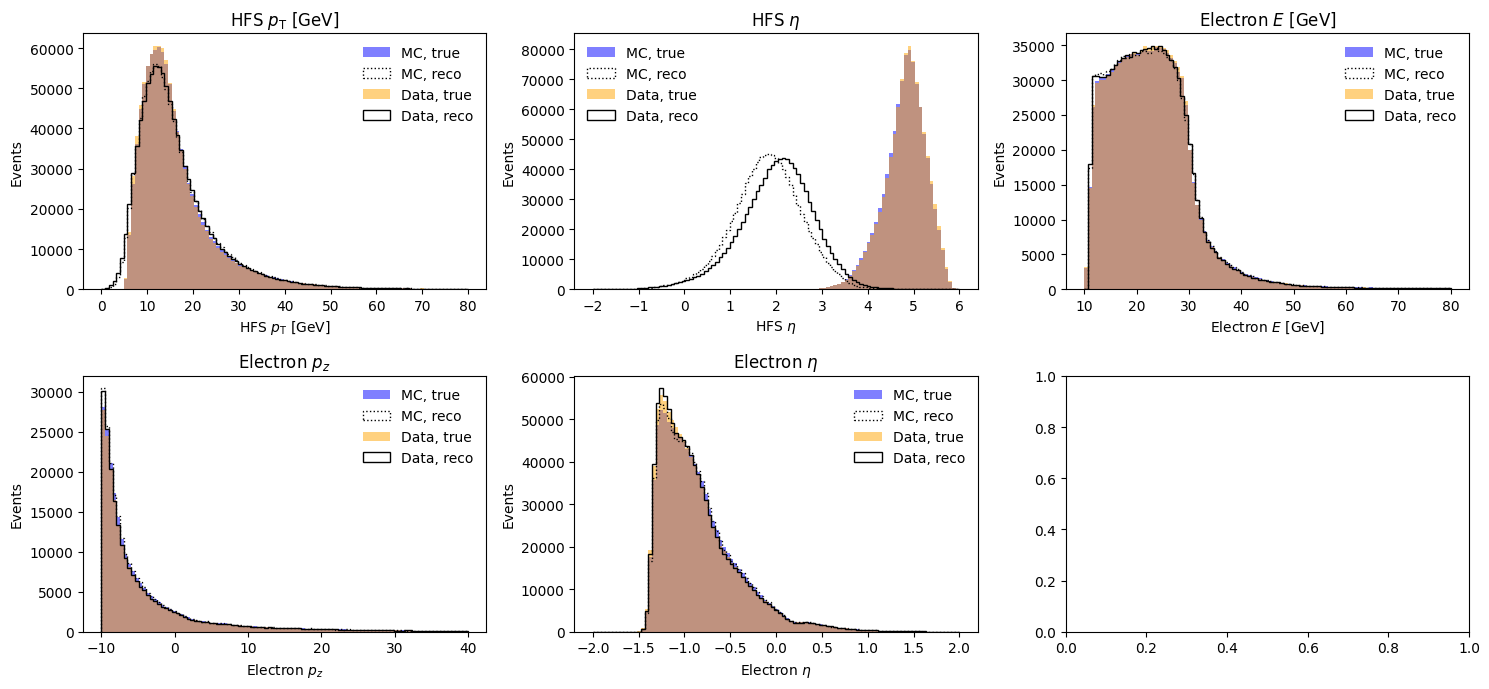

In [15]:
N = len(obs_features)

binning = [
    np.linspace(0, 80, 100),
    np.linspace(-2, 6, 100),
    np.linspace(10, 80, 100),
    np.linspace(-10, 40, 100),
    np.linspace(-2, 2, 100),
]

fig, axes = plt.subplots(2, 3, figsize=(15, 7))

for i, ax in enumerate(axes.ravel()):
    if i >= N:
        break
    _, _, _ = ax.hist(theta0_G[:, i], binning[i], color='blue', alpha=0.5, label="MC, true")
    _, _, _ = ax.hist(theta0_S[:, i], binning[i], histtype="step", color='black', ls=':', label="MC, reco")
    _, _, _ = ax.hist(theta_unknown_G[:, i], binning[i], color='orange', alpha=0.5, label="Data, true")
    _, _, _ = ax.hist(theta_unknown_S[:, i], binning[i], histtype="step", color='black', label="Data, reco")

    ax.set_title(labels[i])
    ax.set_xlabel(labels[i])
    ax.set_ylabel("Events")
    ax.legend(frameon=False)

fig.tight_layout()

In [16]:
inputs = Input((len(obs_features),))
hidden_layer_1 = Dense(50, activation='relu')(inputs)
hidden_layer_2 = Dense(100, activation='relu')(hidden_layer_1)
hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)
outputs = Dense(1, activation='sigmoid')(hidden_layer_3)
model_dis = Model(inputs=inputs, outputs=outputs)

In [17]:
N_Iterations = 4
# Normalize the data before training
theta0_G_norm, _, _ = of.dis_preprocessing(theta0_G)
theta0_S_norm, mean, std = of.dis_preprocessing(theta0_S)
theta_unknown_S_norm, _, _ = of.dis_preprocessing(
    theta_unknown_S, mean, std
)  # We want to use the same mean and std applied to MC here

# OmniFold returns an array of weights with shape [N_iterations,2,N] with the weights for each iteration in step 1 and 2
myweights = of.omnifold(theta0_G_norm, theta0_S_norm, theta_unknown_S_norm, N_Iterations, model_dis)


ITERATION: 1

STEP 1

100/100 [==============================] - 0s 658us/step

STEP 2

100/100 [==============================] - 0s 682us/step

ITERATION: 2

STEP 1

100/100 [==============================] - 0s 661us/step

STEP 2

100/100 [==============================] - 0s 667us/step

ITERATION: 3

STEP 1

100/100 [==============================] - 0s 684us/step

STEP 2

100/100 [==============================] - 0s 652us/step

ITERATION: 4

STEP 1

100/100 [==============================] - 0s 688us/step

STEP 2

100/100 [==============================] - 0s 667us/step


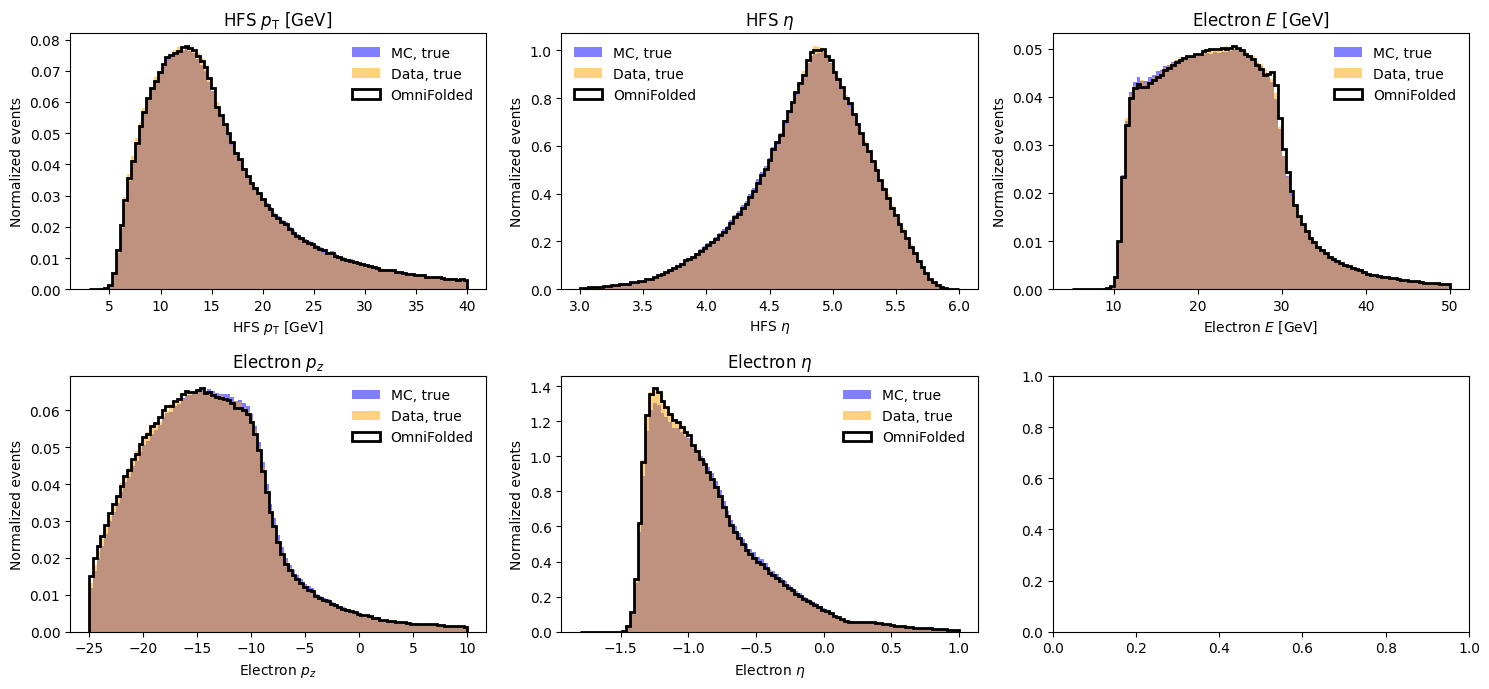

In [28]:
fig, axes = plt.subplots(2, 3, figsize=(15, 7))

gen_binning = [
    np.linspace(3, 40, 100),
    np.linspace(3, 6, 100),
    np.linspace(5, 50, 100),
    np.linspace(-25, 10, 100),
    np.linspace(-1.8, 1.0, 100),
]

for i, ax in enumerate(axes.ravel()):
    if i >= N:
        break
    _, _, _ = ax.hist(theta0_G[:, i], gen_binning[i], color='blue', alpha=0.5, label="MC, true", density=True)
    _, _, _ = ax.hist(theta_unknown_G[:, i], gen_binning[i], color='orange', alpha=0.5, label="Data, true", density=True)
    _, _, _ = ax.hist(
        theta0_G[:, i],
        weights=myweights[-1, 1, :],
        bins=gen_binning[i],
        color='black',
        histtype="step",
        label="OmniFolded",
        lw=2,
        density=True,
    )

    ax.set_title(labels[i])
    ax.set_xlabel(labels[i])
    ax.set_ylabel("Normalized events")
    ax.legend(frameon=False)

fig.tight_layout()

___
___

# OmniFold: DIY

### 1. Plot _unfolded_ electron observables: $\Sigma_e = E_e - p_{z,e}, \ \ \theta = 2\arctan(e^{-\eta})$

hint: unfolded distributions are just weighted histograms

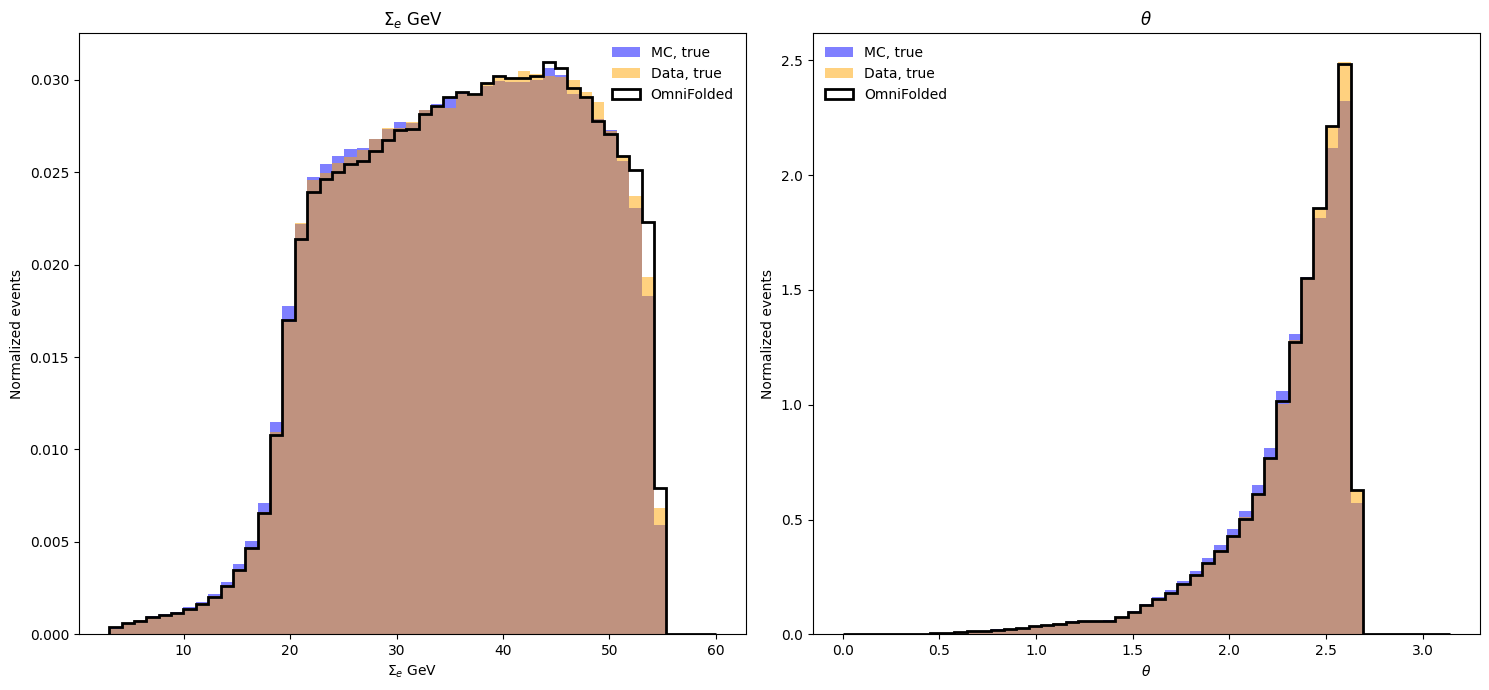

In [19]:
# let's create these variables
sigma_e = theta0_G[:, 2] - theta0_G[:, 3]
theta = 2 * np.arctan(np.exp(-theta0_G[:, 4]))

sigma_e_truth = theta_unknown_G[:, 2] - theta_unknown_G[:, 3]
theta_truth = 2 * np.arctan(np.exp(-theta_unknown_G[:, 4]))

# Now we just gotta plot!
fig, axes = plt.subplots(1, 2, figsize=(15, 7))

binning = [np.linspace(3, 60, 50), np.linspace(0, 3.14, 50)]
to_plot = [sigma_e, theta]
to_plot_truth = [sigma_e_truth, theta_truth]
names = [r'$\Sigma_e$ GeV', r'$\theta$']

for i, ax in enumerate(axes.ravel()):
    _, _, _ = ax.hist(to_plot[i], binning[i], color='blue', alpha=0.5, label="MC, true", density=True)
    _, _, _ = ax.hist(to_plot_truth[i], binning[i], color='orange', alpha=0.5, label="Data, true", density=True)
    _, _, _ = ax.hist(
        to_plot[i],
        weights=myweights[-1, 1, :],
        bins=binning[i],
        color='black',
        histtype="step",
        label="OmniFolded",
        lw=2,
        density=True,
    )

    ax.set_title(names[i])
    ax.set_xlabel(names[i])
    ax.set_ylabel("Normalized events")
    ax.legend(frameon=False)

fig.tight_layout()

### 2. Plot at _unfolded_ x,y, and $Q^2$ distribution for $E_0 = 27.6$ GeV

Hint: $y = 1-\frac{\Sigma_e}{2E_0}, \ \ Q^2 = \frac{E_e^2sin^2\theta}{1-y}, \ \ x\cdot E_p = \frac{E_e(1+\cos\theta)}{2y}$

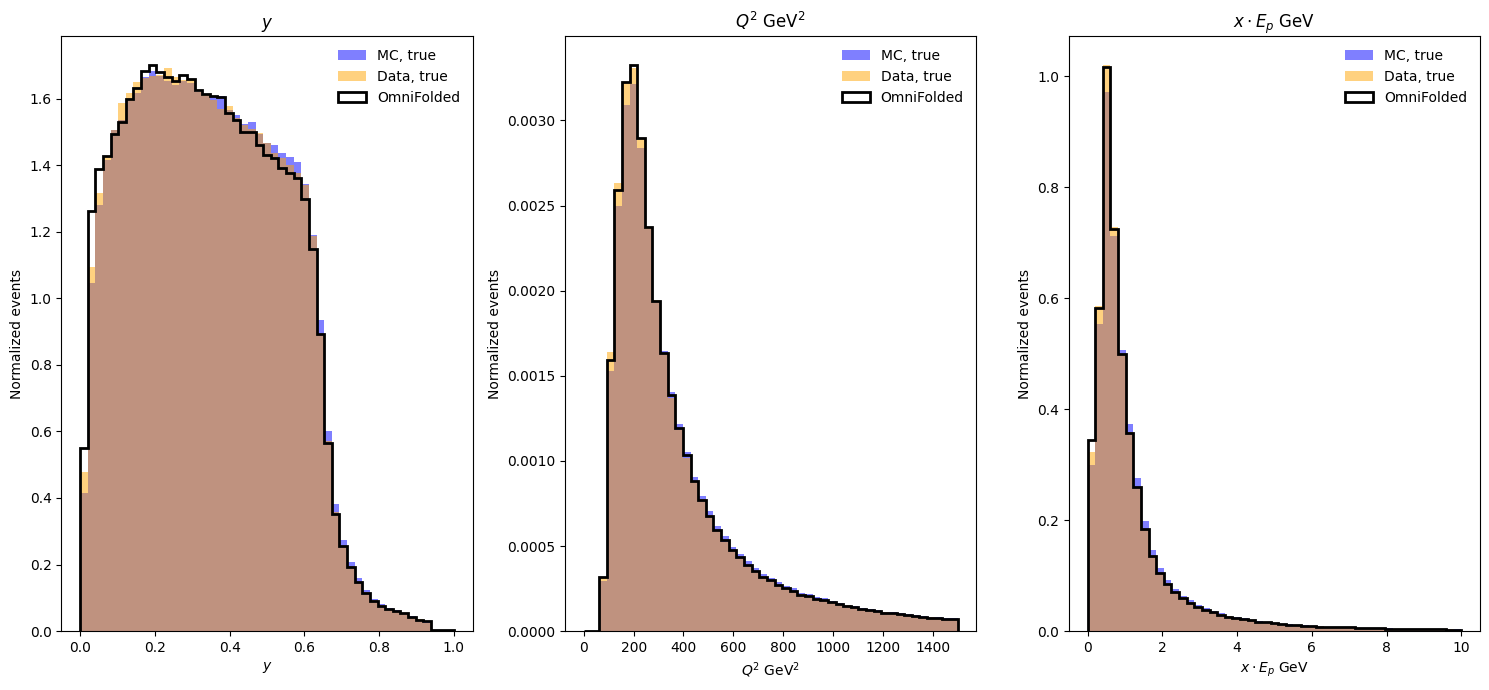

In [29]:
y = 1 - sigma_e / (2 * 27.6)
Q2 = (theta0_G[:, 2] * np.sin(theta)) ** 2 / (1 - y)
xep = theta0_G[:, 2] * (1 + np.cos(theta)) / 2 * y

y_truth = 1 - sigma_e_truth / (2 * 27.6)
Q2_truth = (theta_unknown_G[:, 2] * np.sin(theta_truth)) ** 2 / (1 - y_truth)
xep_truth = theta_unknown_G[:, 2] * (1 + np.cos(theta_truth)) / 2 * y_truth


# Now we just gotta plot!
fig, axes = plt.subplots(1, 3, figsize=(15, 7))

binning = [np.linspace(0, 1, 50), np.linspace(0, 1500, 50), np.linspace(0, 10, 50)]
to_plot = [y, Q2, xep]
to_plot_truth = [y_truth, Q2_truth, xep_truth]
names = [r'$y$', r'$Q^2$ GeV$^2$', '$x\cdot E_p$ GeV']

for i, ax in enumerate(axes.ravel()):
    _, _, _ = ax.hist(to_plot[i], binning[i], color='blue', alpha=0.5, label="MC, true", density=True)
    _, _, _ = ax.hist(to_plot_truth[i], binning[i], color='orange', alpha=0.5, label="Data, true", density=True)
    _, _, _ = ax.hist(
        to_plot[i],
        weights=myweights[-1, 1, :],
        bins=binning[i],
        color='black',
        histtype="step",
        label="OmniFolded",
        lw=2,
        density=True,
    )

    ax.set_title(names[i])
    ax.set_xlabel(names[i])
    ax.set_ylabel("Normalized events")
    ax.legend(frameon=False)

fig.tight_layout()

### 3. Plot the mean electron $\eta$ versus $Q^2$, the energy scale

hint: How do you calculate the mean of weighted distributions?

In [30]:
# Let's first define a few Q^2 intervals we want to use
Q2_intervals = np.linspace(0, 1500, 5)
means = []
means_omnifold = []
means_truth = []
# Now, let's only look at data that passes the selection
for q2_bin in range(Q2_intervals.shape[0] - 1):
    mask = (Q2 > Q2_intervals[q2_bin]) & (Q2 < Q2_intervals[q2_bin + 1])
    eta_sel = theta0_G[mask, 4]
    weights_sel = weights = myweights[-1, 1, mask]
    means_omnifold.append(np.average(eta_sel, weights=weights_sel))
    means.append(np.average(eta_sel))

    # Let's get the truth distributions for comparison
    mask_truth = (Q2_truth > Q2_intervals[q2_bin]) & (Q2_truth < Q2_intervals[q2_bin + 1])
    eta_sel_truth = theta_unknown_G[mask_truth, 4]
    means_truth.append(np.average(eta_sel_truth))

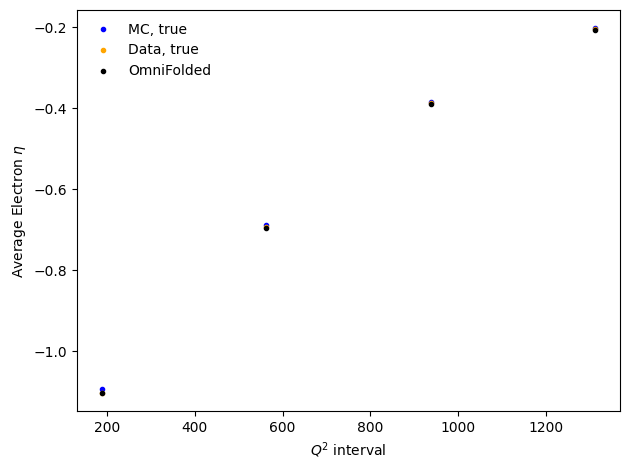

In [31]:
# Let's plot!
Q2_axis = 0.5 * (Q2_intervals[:-1] + Q2_intervals[1:])
plt.plot(Q2_axis, means, '.', color='blue', label="MC, true")
plt.plot(Q2_axis, means_truth, '.', color='orange', label="Data, true")
plt.plot(Q2_axis, means_omnifold, '.', color='black', label="OmniFolded")

plt.xlabel(r'$Q^2$ interval')
plt.ylabel(r"Average Electron $\eta$")
plt.legend(frameon=False)
plt.tight_layout()